# LSA

잠재 의미 분석(Latent Semantic Analysis, LSA)을 통해 단어 벡터화 기법을 실습하고 단어 간 유사도를 구해볼 것입니다. 여기서의 코드 예제 및 설명은 《밑바닥부터 시작하는 딥러닝 2》를 참고했습니다.

## PTB 데이터 불러오기

**펜 트리뱅크**(Penn Treebank, PTB) 데이터셋. word2vec 발명자인 토마스 미콜로프(Tomas Mikolov) 웹 페이지에서 받을 수 있습니다. 원래의 PTB 문장에 몇 가지 전처리가 되어있습니다. 희소한 단어는 `<unk>`로 치환되어 있다던가, 구체적인 숫자는 `N`으로 대체되어 있습니다.

In [1]:
import os

if 'ptb.train.txt' in os.listdir('./data'):
    with open("./data/ptb.train.txt", 'r') as f:
        text = f.read()        
else:
    from urllib.request import urlopen
    url = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/ptb.train.txt'
    html = urlopen(url)
    text = html.read().decode()

    with open("./data/ptb.train.txt", 'w') as f:
        f.write(text)

## 통계기반 벡터화

동시발행 행렬을 만들고, PPMI 행렬로 변환한 다음, 안정성을 높이기 위해 SVD를 이용해 차원을 감소시켜 각 단어의 분산 표현을 만들어냅니다.

### 함수 정의

In [2]:
import numpy as np

# 전처리
def preprocess(text):
    
    words = text.replace('\n', '<eos>').strip().split()
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

# 동시발생 행렬 만들기
def create_co_matrix(corpus, vocab_size, window_size):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size))
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx-i
            right_idx = idx+i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

# 양의 상호정보량 구하기
def ppmi(C, eps=1e-8):
    N = np.sum(C)
    S = np.sum(C, axis=0, keepdims=True)
    pmi = np.log2(C * N / np.dot(S.T, S) + eps)
    ppmi = np.maximum(pmi, 0)
    return ppmi

### 실행

In [3]:
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = preprocess(text)
print("동시발생 수 계산 ...")
vocab_size = len(word_to_id)
co_matrix = create_co_matrix(corpus, vocab_size, window_size)
print("PPMI 계산 ...")
W = ppmi(co_matrix)

print("SVD 계산 ...")
from sklearn.decomposition import PCA, TruncatedSVD
# TruncatedSVD(n_components=wordvec_size, algorithm='randomized', n_iter=5)
svd = PCA(wordvec_size)
word_vecs = svd.fit_transform(W) 

동시발생 수 계산 ...
PPMI 계산 ...
SVD 계산 ...


## 평가

특정 단어를 넣었을 때 유사한 단어를 가려낼 수 있는지, 그리고 단어 간 비유적 관계를 찾아낼 수 있는지를 볼 것입니다.

### 함수 정의

In [4]:
# 가장 비슷한 단어 출력
def most_similar(query, word_to_id, id_to_word, similarity_matirx, top=5):
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return
    
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    similarity = similarity_matirx[query_id]
    
    # 코사인 유사도 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return


def analogy(a, b, c, word_to_id, id_to_word, word_vecs, top=5):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_vecs[word_to_id[a]], word_vecs[word_to_id[b]], word_vecs[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    word_vecs_norm = word_vecs / np.linalg.norm(word_vecs, axis=1, keepdims=True)
    similarity = np.dot(word_vecs_norm, query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

### 실행

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matirx = cosine_similarity(word_vecs)

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, similarity_matirx)


[query] you
 i: 0.8206609113936517
 we: 0.8003700893472653
 do: 0.7728013785963217
 'll: 0.746834338115592
 really: 0.6980334721029142

[query] year
 earlier: 0.7798894360846084
 month: 0.7747791483920138
 last: 0.7534767295188
 quarter: 0.718144829677893
 next: 0.6890402260839403

[query] car
 auto: 0.7069211745048384
 luxury: 0.6213613075237677
 domestic: 0.6197783071282318
 cars: 0.5737282860838181
 truck: 0.5733657897232981

[query] toyota
 motor: 0.7564896308425962
 motors: 0.6771316899544664
 mazda: 0.6211671489592199
 nissan: 0.6081789979683243
 lexus: 0.5990222801564462


In [6]:
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 woman: 11.109978954275343
 veteran: 10.112878562462729
 spy: 9.18254148389227
 kate: 9.051702564295685
 neither: 8.705785226223396

[analogy] take:took = go:?
 went: 19.618426734469903
 sent: 17.787972569031126
 goes: 16.053553273364493
 comes: 15.670367737135575
 turns: 15.523764295884254

[analogy] car:cars = child:?
 genes: 10.581216924673198
 cells: 10.131987970480768
 proteins: 9.738929647999385
 bacteria: 9.276133347291076
 elderly: 9.132694486825233

[analogy] good:better = bad:?
 worse: 13.331834322954343
 harder: 9.567695673189087
 larger: 9.274110744367498
 apart: 9.141132657625825
 often: 9.06910099138482


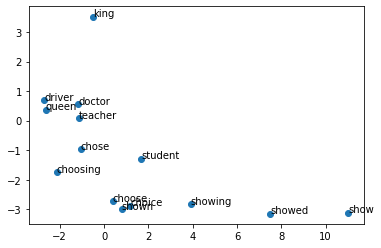

In [7]:
import matplotlib.pyplot as plt

words = ['teacher', 'doctor', 'student', 'driver', 'king', 'queen',
         'show', 'showed', 'showing', 'shown',
         'choose', 'choosing', 'chose', 'choice'
        ]
word_ids = [word_to_id[word] for word in words]

plt.scatter(word_vecs[word_ids, 0], word_vecs[word_ids, 1])
for word in words:
    x = word_vecs[word_to_id[word], 0]
    y = word_vecs[word_to_id[word], 1]
    plt.text(x, y, word)
plt.show()